In [1]:
from src.TimeSeries import TimeSeries
import yfinance as yf

# Descargar cotizaciones de MELI (Mercado Libre)
meli = yf.download('MELI', start='2018-01-01', interval='1wk')
dates = meli.index
meli_prices = meli['Close']['MELI']

ts = TimeSeries('$MELI', dates, meli_prices)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Estacionariedad

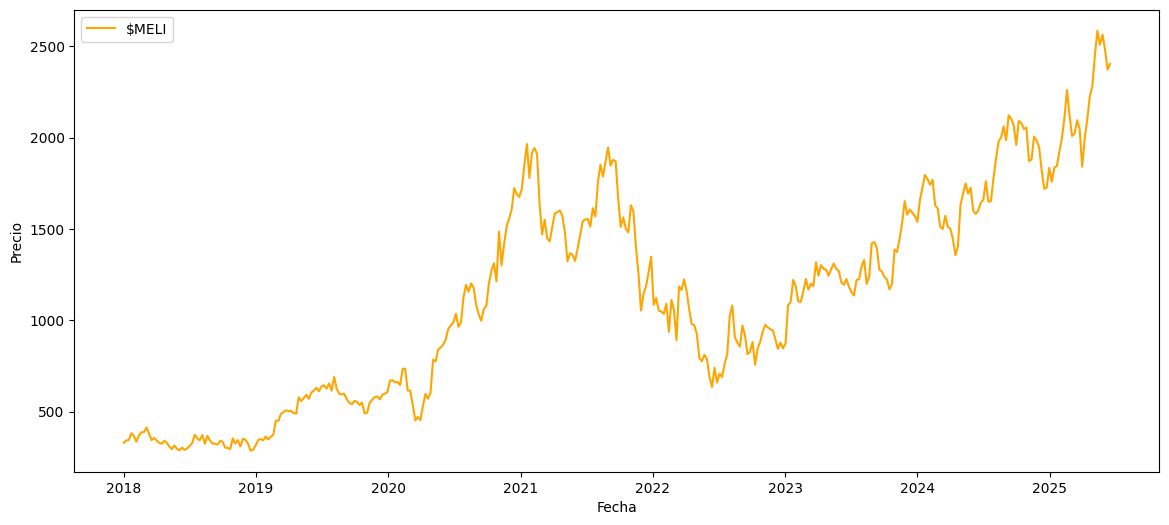

In [2]:
from src.TimeSeriesPlot import TimeSeriesPlot

plot = TimeSeriesPlot(ts)
plot.add_original()
plot.show()

In [3]:
ts.is_stationary()

ADF Statistic: -0.7697190853607586
p-value: 0.8278554626467641

KPSS Statistic: 0.2437167359973814
p-value: 0.01

Decisión: No estacionaria


False

Serie no es estacionaria, probablemente por el trend

In [4]:
diff_times = 1
ts_diff = ts.differentiate(diff_times)

ts_diff.is_stationary()

ADF Statistic: -19.781527772845113
p-value: 0.0

KPSS Statistic: 0.0553438989966349
p-value: 0.1

Decisión: Estacionaria


True

Requiere solo una diferenciación para ser estacionaria. Dato para ARIMA.

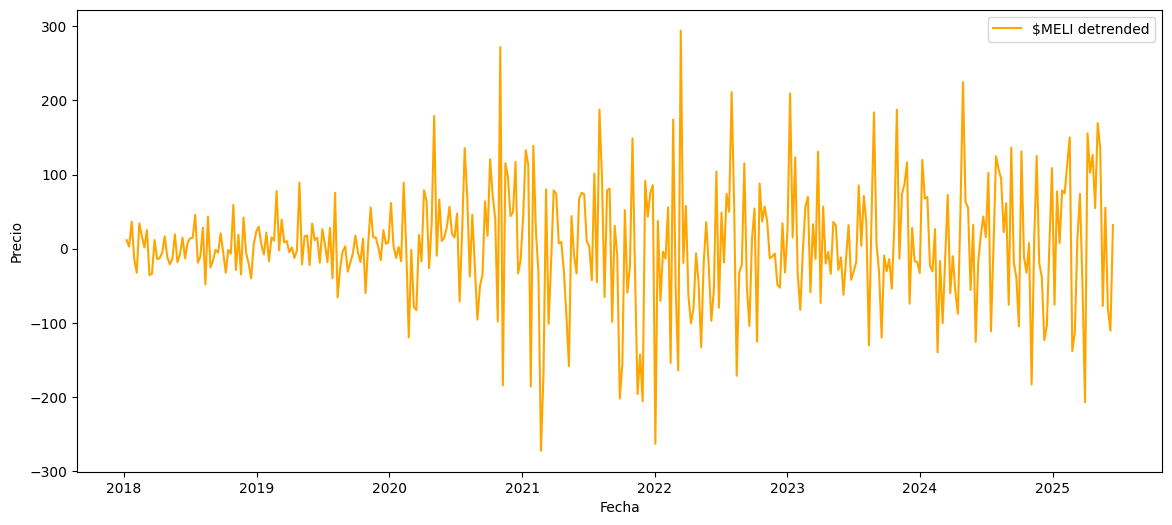

In [5]:
plot = TimeSeriesPlot(ts_diff)
plot.add_original()
plot.show()

## Forecasting 1: ARIMA

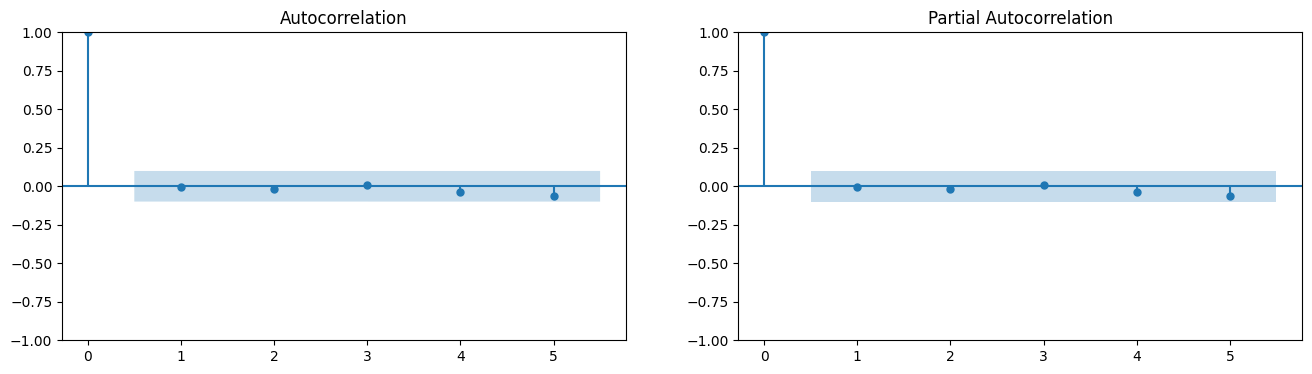

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts_diff.values, ax=axes[0], lags=5)
plot_pacf(ts_diff.values, ax=axes[1], lags=5)
plt.show()


* **p** es el número de términos autoregresivos (AR): cuántos valores pasados influencian el actual.
* **q** es el número de términos de media móvil (MA): cuántos errores pasados se usan.
* **d** es el número de diferenciaciones necesarias para hacer la serie original no estacionaria, en estacionaria.

### Cómo elegirlos:

- Tanto ACF como PACF cortan abruptamente, no desvanecen.
- Tanto p como q se eligen mirando el punto donde cortan, es decir, el último lag significativo antes de que los valores caigan dentro del intervalo de confianza.
    - Si PACF corta en lag k → p = k
    - Si ACF corta en lag k → q = k


In [7]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(ts.values, order=(1,1,1))  # p=1, d=1, q=1 por lo mencionado anteriormente
resultado = modelo.fit()
print(resultado.summary())

                               SARIMAX Results                                
Dep. Variable:                   MELI   No. Observations:                  390
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2247.298
Date:                Sun, 22 Jun 2025   AIC                           4500.597
Time:                        20:03:41   BIC                           4512.488
Sample:                    01-01-2018   HQIC                          4505.311
                         - 06-16-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0012     18.502  -6.37e-05      1.000     -36.265      36.263
ma.L1         -0.0012     18.500  -6.49e-05      1.000     -36.260      36.258
sigma2      6159.7293    344.464     17.882      0.0

/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

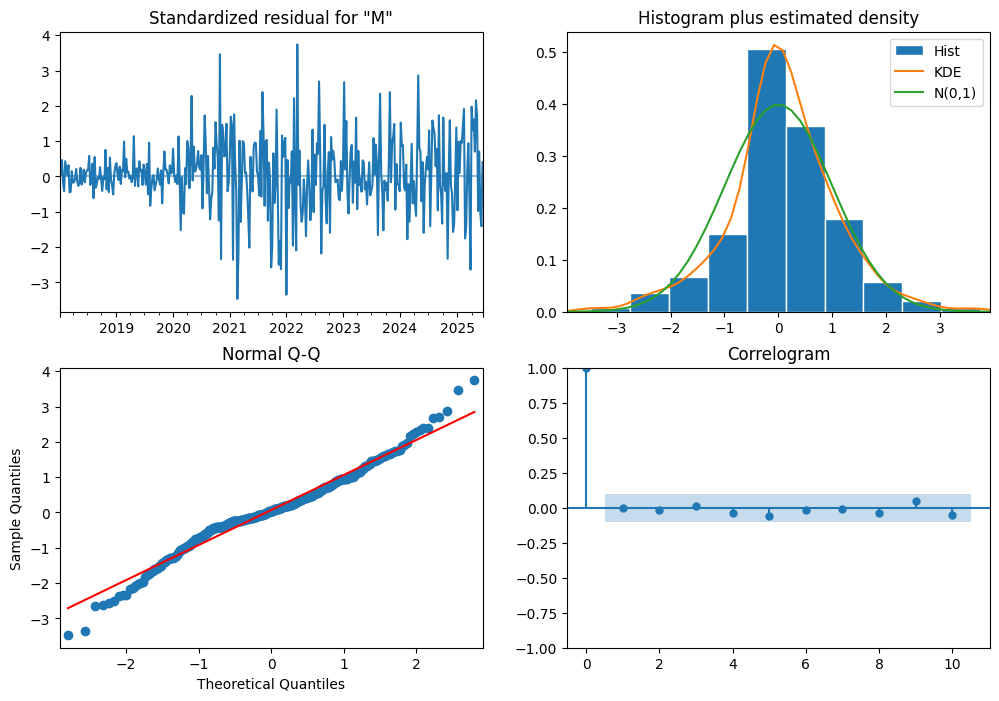

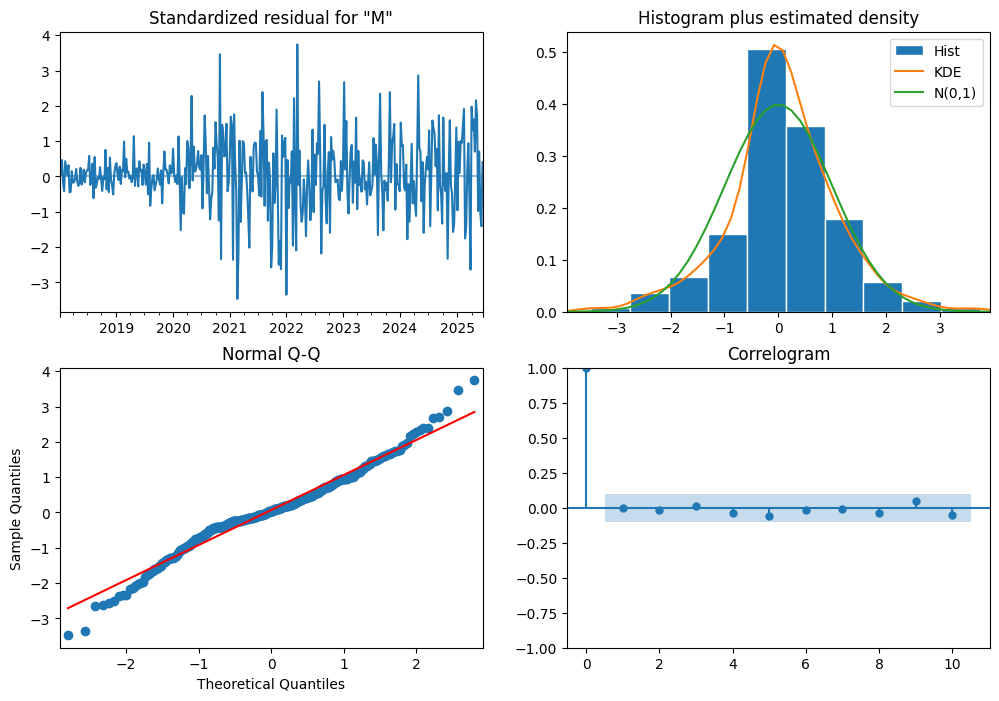

In [8]:
resultado.plot_diagnostics(figsize=(12,8))

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error

#ARIMA
# División 70% entrenamiento, 30% test
size = int(len(ts.values) * 0.7)
train, test = ts.values[:size], ts.values[size:]

history = train.tolist()
predictions = []

# Rolling forecast paso a paso
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast()          # pronóstico 1 paso adelante
    yhat = forecast[0]                       # valor pronosticado
    predictions.append(yhat)                 # guardar pronóstico
    obs = test.iloc[t]                       # dato real
    history.append(obs)                      # actualizar historial con valor real

RMSE Rolling ARIMA: 85.6993


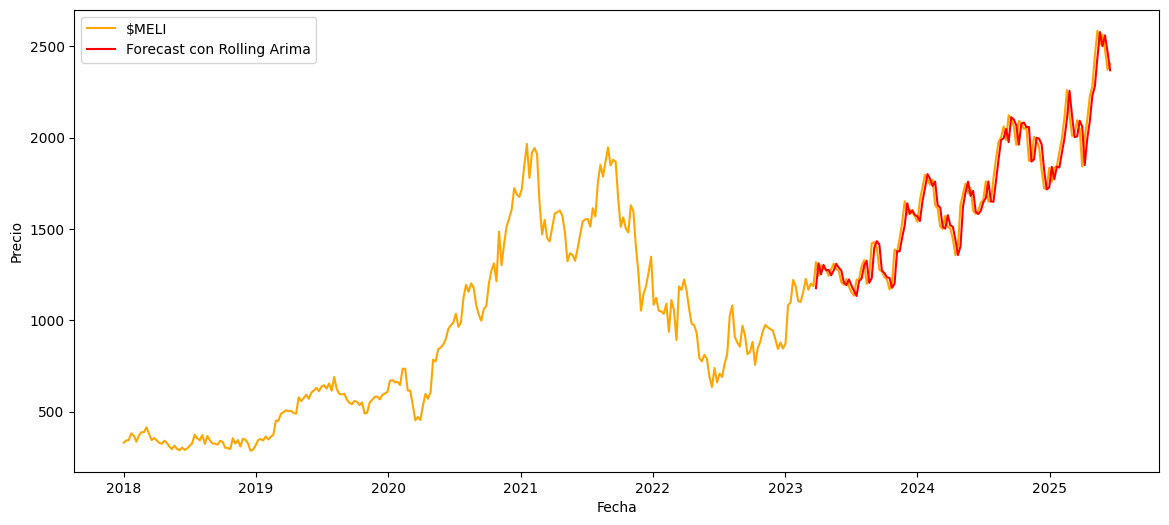

In [10]:
# Calcular RMSE
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE Rolling ARIMA: {rmse:.4f}')

ts_forecast = TimeSeries('Forecast con Rolling Arima', ts.dates[size:], predictions)

plot = TimeSeriesPlot(ts)
plot.add_original()
plot.add_another(ts_forecast)
plot.show()

## Forecasting 2: LSTMs

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
import tensorflow as tf

In [84]:
# Semilla para reproducibilidad
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

# Datos
values = ts.values.astype('float32')

# Normalización MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values.to_numpy().reshape(-1, 1))

# Split 70% train, 30% test
split_index = int(len(values_scaled) * 0.7)
train, test = values_scaled[:split_index], values_scaled[split_index:]

look_back = 5

# Función para crear datasets supervisados
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

# Crear datasets para train y test
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# --- Función para entrenar modelo stateful ---
def fit_lstm(trainX, trainY, epochs=1, neurons=4, batch_size=1, stateful=True):
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, look_back, 1)))
    lstm_layer = LSTM(neurons, stateful=stateful)
    model.add(lstm_layer)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(epochs):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False, verbose=0)
        lstm_layer.reset_states()   # Reseteo acá
    return model

# Ajustar batch_size a 1 para stateful y predicciones paso a paso
batch_size = 1
neurons = 75
epochs = 25

In [85]:
# --- Entrenar modelo para rolling forecast ---
model_rolling = fit_lstm(X_train, y_train, epochs=epochs, neurons=neurons, batch_size=batch_size, stateful=False)

# --- Rolling forecast ---
predictions_rolling = []
test_1d = test.reshape(-1)  # array 1D para slicing

for i in range(len(test_1d) - look_back):
    X_input = test_1d[i:i+look_back].reshape(1, look_back, 1)
    yhat = model_rolling.predict(X_input, batch_size=1, verbose=0)
    predictions_rolling.append(yhat[0, 0])

predictions_rolling_inv = scaler.inverse_transform(np.array(predictions_rolling).reshape(-1,1))
y_test_inv_rolling = scaler.inverse_transform(test[look_back:].reshape(-1,1))

rmse_rolling = np.sqrt(mean_squared_error(y_test_inv_rolling, predictions_rolling_inv))
print(f'Rolling LSTM RMSE: {rmse_rolling:.4f}')

forecast_dates_rolling = ts.dates[split_index + look_back:]
ts_forecast_rolling = TimeSeries(f'Rolling Forecast (batch_size={batch_size})', forecast_dates_rolling, predictions_rolling_inv.flatten())

Rolling LSTM RMSE: 290.3972


In [86]:
# --- Entrenar modelo para forecast normal ---
batch_size = 16

model_normal = fit_lstm(X_train, y_train, epochs=epochs, neurons=neurons, batch_size=batch_size, stateful=False)

# --- Forecast normal (batch predict) ---
predictions_normal = model_normal.predict(X_test, batch_size=batch_size)

predictions_normal_inv = scaler.inverse_transform(predictions_normal)
y_test_inv_normal = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_normal = np.sqrt(mean_squared_error(y_test_inv_normal, predictions_normal_inv))
print(f'Normal LSTM RMSE: {rmse_normal:.4f}')

forecast_dates_normal = ts.dates[split_index + look_back:]
ts_forecast_normal = TimeSeries(f'Normal Forecast (batch_size={batch_size}', forecast_dates_normal, predictions_normal_inv.flatten())

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Normal LSTM RMSE: 137.8201


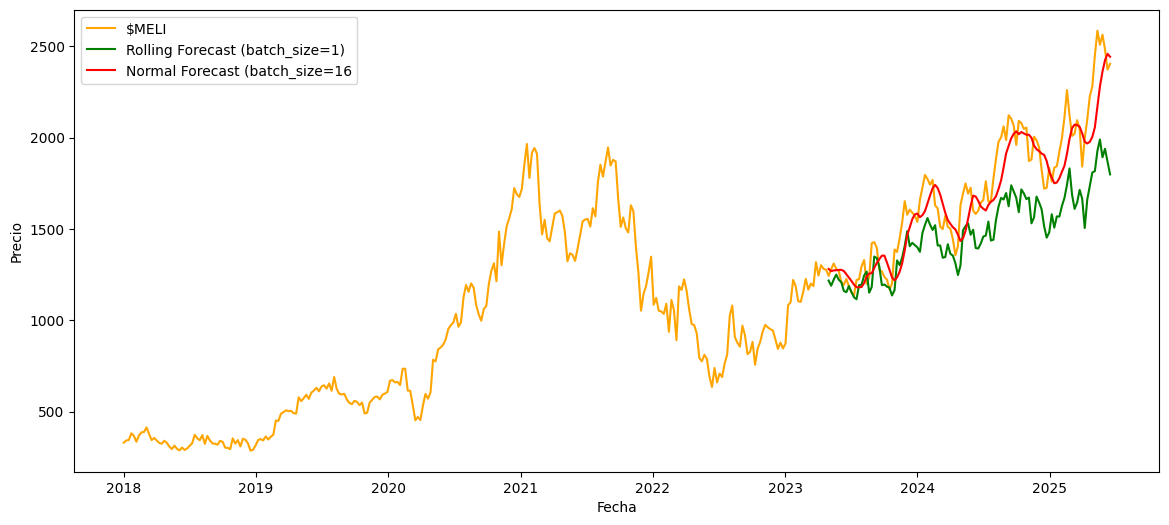

In [87]:
# --- Graficar ambos y la serie original ---
plot = TimeSeriesPlot(ts)
plot.add_original()
plot.add_another(ts_forecast_rolling, 'green')  # Rolling forecast
plot.add_another(ts_forecast_normal, 'red')    # Normal forecast
plot.show()